# Text from FOMC meeting minutes

Concepts:

## Web-scraping

## Text processing, NLP

## Topic modelling


Author: Terence Lim

References:

- https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html                                                                                                                
- Di and Jegadeesh, Deciphering Fedspeak: The Informational Content of FOMC Meetings"                         
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2939937

In [2]:
%matplotlib inline
import dives
import dives.dbengines
import dives.unstructured
import dives.custom
import dives.util
from wordcloud import WordCloud, STOPWORDS
import sklearn.feature_extraction
import matplotlib.pyplot as plt
import numpy as np
import re
from pprint import pprint

from dives.util import DataFrame, wordcloud_features
from dives.dbengines import MongoDB
from dives.unstructured import Unstructured
from dives.custom import CustomTokenizer

try:
    import secret
    verbose = secret.value('verbose')
except:
    raise ImportError("Create module:secret.py, with method:value(arg) to return its secret value")

mongodb = MongoDB(**secret.value('mongodb'))


### Scrape Federal Reserve website
- helper function to get_catalog of web page links, and get_minutes to retrieve text
- Note: first section of minutes usually on administrative (non-economic) matters which should be removed

In [6]:
import re
import requests
from bs4 import BeautifulSoup
def get_catalog(root_url= 'https://www.federalreserve.gov/'):
    """helper function to get dict of dates and urls of FOMC minutes from federal website"""

    dateOf = lambda s: int(re.sub('\D', '', s)[-8:])

    # latest five years' minutes can be linked from a main page                                             
    new_url = root_url + 'monetarypolicy/fomccalendars.htm'
    raw   = BeautifulSoup(requests.get(new_url).content, 'html.parser')
    hrefs = raw.find_all('a', href=re.compile('\S+minutes\S+.htm$', re.IGNORECASE))
    links = [root_url + m.attrs['href'] for m in hrefs]

    # but earlier years' minutes are linked from annual pages with this url format                          
    old_url = root_url + 'monetarypolicy/fomchistorical%d.htm'
    for year in range(1993, min([dateOf(m) for m in links]) // 10000):
        raw = BeautifulSoup(requests.get(old_url % year).content, 'html.parser')
        hrefs = raw.find_all('a', href=re.compile('\S+minutes\S+.htm$', re.IGNORECASE))
        links += [root_url + m.attrs['href'].replace(root_url,'') for m in hrefs]
    return {dateOf(link) : link for link in links}

def get_minutes(date, url):
    """helper function to retrieve a minutes document for {date} from {url} at fed website"""
    raw = BeautifulSoup(requests.get(url).content, 'html.parser')
    minutes = "\n\n".join([p.get_text().strip() for p in raw.findAll('p')])
    return {'url' : url,
            'date' : date,
            'text' : re.sub('\n+','\n', re.sub('[\r\t]','', minutes))}

catalog = get_catalog()
print("Sample of url's")
pprint([(c,catalog[c]) for c in np.random.choice(list(catalog.keys()), 2)])

docs = {date : get_minutes(date, url) for date,url in catalog.items()}
dates = sorted(docs.keys())
print("{} FOMC minutes read from {} to {}".format(len(dates), dates[0], dates[-1]))

print("Sample of tail of latest doc")
doc = re.sub('\n+','\n', re.sub('[\r\t]',' ', docs[dates[-1]]['text'])).split('\n')
for num, line in enumerate(doc[-50:]):
    print('[%4d] %s' % (num+len(doc)-50, line[:70]))



Sample of url's
[(20050920, 'https://www.federalreserve.gov//fomc/minutes/20050920.htm'),
 (19950926,
  'https://www.federalreserve.gov//fomc/MINUTES/1995/19950926min.htm')]
215 FOMC minutes read from 19930203 to 20191211
Sample of tail of latest doc
[ 133] The staff's forecast for total PCE price inflation in 2019 was revised
[ 134] The staff continued to view the uncertainty around its projections for
[ 135] Participants' Views on Current Conditions and the Economic Outlook
[ 136] In conjunction with this FOMC meeting, members of the Board of Governo
[ 137] Participants agreed that the labor market had remained strong over the
[ 138] Participants generally expected sustained expansion of economic activi
[ 139] In their discussion of the household sector, participants agreed that 
[ 140] With respect to the business sector, participants saw trade developmen
[ 141] A number of participants commented on challenges facing the energy and
[ 142] Participants judged that conditions in the l

### Retrieve minutes and stopwords documents from mongodb store of unstructured data

In [7]:
    minutes = Unstructured(mongodb, 'minutes1')
    docs = {doc['date']: doc for doc in list(minutes.mongo.find({},{'_id':0}))}
    #for d in sorted(docs.keys()):                                                                          
    #    print(d, len(docs[d]['text']))   # print doc length in chars                                       
    #with gzip.GzipFile('/home/terence/Downloads/out/minutes.json.gz','w') as f:                            
    #    f.write(json.dumps(docs).encode('utf-8'))   # to save a json copy of minutes                       
    dates = sorted(docs.keys())
    text = [docs[date]['text'] for date in dates]
    dates = sorted(docs.keys())
    print("{} docs read from {} to {}".format(len(dates), dates[0], dates[-1]))

    wordlist = Unstructured(mongodb, 'wordlists')
    stopwords = wordlist.find_values('genericlong')[0]   # GenericLong stop words from LoughranMcDonald     
    stopwords = ['january','february','march','april','may', 'june', 'july','august','september',
                 'october','november','december', 'first', 'second', 'third', 'fourth', 'twelve'
                 ] + CustomTokenizer()(" ".join(stopwords))


215 docs read from 19930203 to 20191211


### Define ML pipelines, fit topic models
- tokenizers
- term frequency vectorizers (tf, tfidf)
- sklearn decomposition models (LSA, NMF, LDA, PLSI)

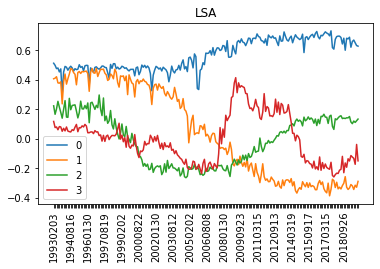

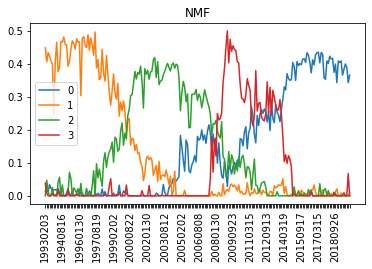

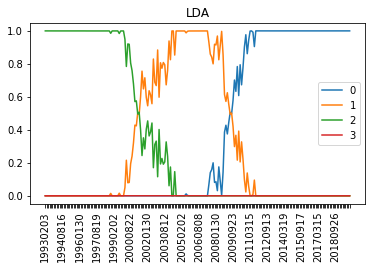

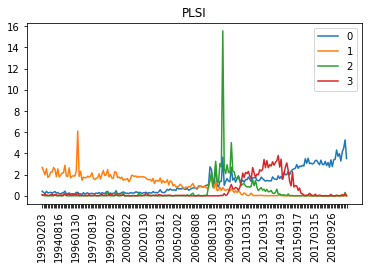

In [8]:
    max_df, min_df, max_features = 0.95, 3, 10000   # reasonable constraints for feature selection          
    tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
        strip_accents='unicode',
        lowercase=True,
        stop_words=stopwords,
        max_df=max_df, min_df=min_df, max_features=max_features,
        tokenizer=CustomTokenizer())  # token_pattern=r'\b[^\d\W]+\b'                                       
    tf_vectorizer = sklearn.feature_extraction.text.CountVectorizer(
        strip_accents='unicode',
        lowercase=True,
        stop_words=stopwords,
        max_df=max_df, min_df=min_df, max_features=max_features,
        tokenizer=CustomTokenizer())  # token_pattern=r'\b[^\d\W]+\b'                                       

    n_components = 4
    algos = {'LSA' : (sklearn.decomposition.TruncatedSVD(n_components=n_components),
                      tfidf_vectorizer),
             'NMF' : (sklearn.decomposition.NMF(n_components = n_components,
                                                random_state = 42, alpha = 0.1, l1_ratio = 0.5),
                      tfidf_vectorizer),
             'LDA' : (sklearn.decomposition.LatentDirichletAllocation(n_components = n_components,
                                                                      learning_method = 'online',
                                                                      learning_offset = 50.0,
                                                                      max_iter = 5, random_state = 42),
                      tf_vectorizer),
             'PLSI' : (sklearn.decomposition.NMF(n_components = n_components,
                                                 beta_loss='kullback-leibler', solver='mu',
                                                 alpha = 0.1, l1_ratio = 0.5,
                                                 max_iter=1000, random_state = 42),
                       tf_vectorizer),
    }
    models = dict()
    for name, (base, vectorizer) in algos.items():
        vectorized = vectorizer.fit_transform(text)
        feature_names = vectorizer.get_feature_names()
        models[name] = base.fit(vectorized)

        # transform to reduced dimension space, and plot over topic score over time                         
        topics = models[name].transform(vectorized)
        ax = plt.gca()
        ax.plot(np.array(dates).astype(str), topics)
        plt.xticks(np.array(dates).astype(str), rotation='vertical')
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n % 12 != 0:
                label.set_visible(False)
        plt.legend(np.arange(n_components).astype(str))
        plt.title(name)
        plt.subplots_adjust(bottom=0.25)  # prevent clipping of tick labels                                 
        plt.show()

### Display top features and plot wordclouds

Model LSA


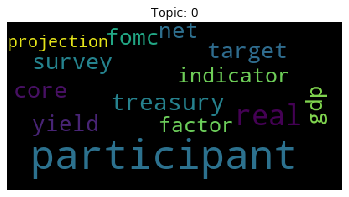

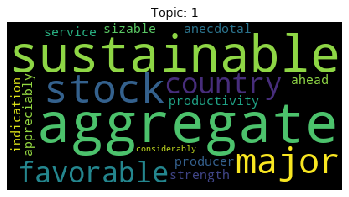

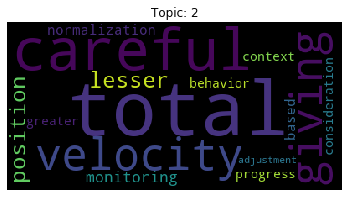

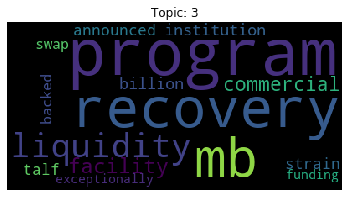

Model LSA, Topic (0) top unique features:
[('participant', 0.36638336812969036),
 ('real', 0.14357975733107717),
 ('treasury', 0.09636506735186914),
 ('core', 0.08964279146642923),
 ('target', 0.08856376599061055),
 ('survey', 0.08674537245561591),
 ('yield', 0.0806441991732826),
 ('fomc', 0.07804654128929862),
 ('gdp', 0.07569438181889199),
 ('net', 0.07483992044514062),
 ('indicator', 0.07418022687843735),
 ('factor', 0.07129607987116364),
 ('projection', 0.06695763685574727)]
Model LSA, Topic (1) top unique features:
[('aggregate', 0.11060229201813933),
 ('sustainable', 0.10414592333478741),
 ('stock', 0.08487225490813669),
 ('major', 0.08296681241390899),
 ('country', 0.08041339688651075),
 ('favorable', 0.07970348535640528),
 ('productivity', 0.07947071429760892),
 ('producer', 0.07698721152787744),
 ('service', 0.07683294442878373),
 ('strength', 0.07624747655097612),
 ('ahead', 0.07390303816341635),
 ('anecdotal', 0.07293413010936098),
 ('indication', 0.07139444547587728),
 ('ap

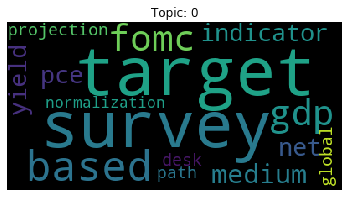

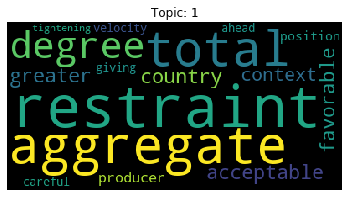

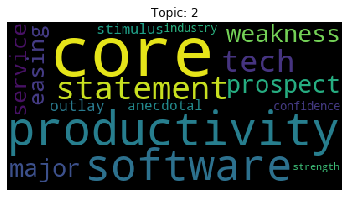

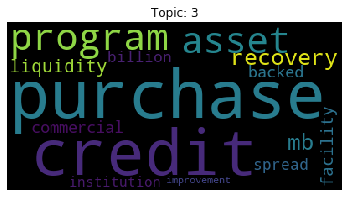

Model NMF, Topic (0) top unique features:
[('target', 0.27571053782716043),
 ('survey', 0.25605972565270574),
 ('based', 0.2183265483295515),
 ('fomc', 0.20685280594125738),
 ('gdp', 0.20267519626878003),
 ('medium', 0.18652231432027278),
 ('indicator', 0.18246146790601758),
 ('pce', 0.1770816624200971),
 ('yield', 0.1713625842693267),
 ('net', 0.16904288010205518),
 ('projection', 0.15895995029137472),
 ('desk', 0.15767154316638998),
 ('path', 0.15507495786295156),
 ('global', 0.15467978169698732),
 ('normalization', 0.1516573880008364)]
Model NMF, Topic (1) top unique features:
[('restraint', 0.24490641965033785),
 ('aggregate', 0.19419988391774604),
 ('total', 0.1724899970694329),
 ('degree', 0.1524639405777076),
 ('acceptable', 0.14348403675887242),
 ('country', 0.14239948008503947),
 ('greater', 0.1408581299043028),
 ('favorable', 0.13314463707307483),
 ('context', 0.13247546656522274),
 ('producer', 0.13103431428124146),
 ('position', 0.1276698462114902),
 ('velocity', 0.12671616

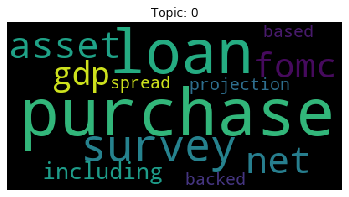

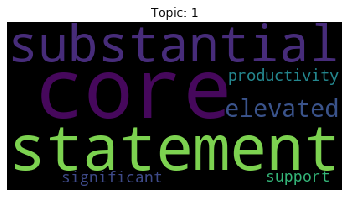

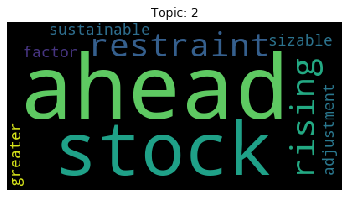

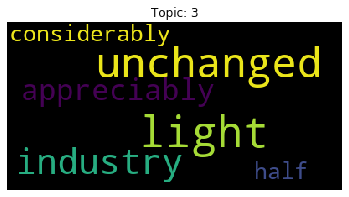

Model LDA, Topic (0) top unique features:
[('purchase', 695.8260434390829),
 ('loan', 585.9183697047979),
 ('survey', 563.0965529313835),
 ('asset', 478.54236392816694),
 ('net', 464.1670362514576),
 ('fomc', 418.91677825004376),
 ('gdp', 402.16385720328014),
 ('including', 392.9497948656405),
 ('projection', 389.5232631696572),
 ('based', 376.7687880936769),
 ('spread', 359.9690197436507),
 ('backed', 352.04220418458823)]
Model LDA, Topic (1) top unique features:
[('core', 217.5432858804342),
 ('statement', 134.02170365294447),
 ('substantial', 124.77178664801933),
 ('elevated', 104.17706686182473),
 ('productivity', 100.11944535759551),
 ('significant', 98.95377601553515),
 ('support', 97.82661403901388)]
Model LDA, Topic (2) top unique features:
[('ahead', 128.3583510918155),
 ('stock', 126.42841445482655),
 ('restraint', 118.45532550730299),
 ('rising', 117.4933700838567),
 ('sustainable', 112.43138130614312),
 ('factor', 107.47085208316597),
 ('adjustment', 106.1718131158952),
 ('

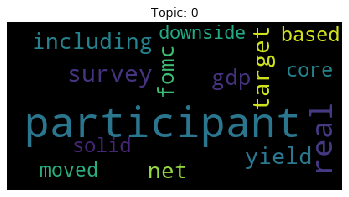

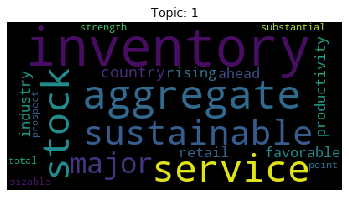

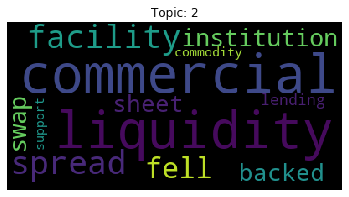

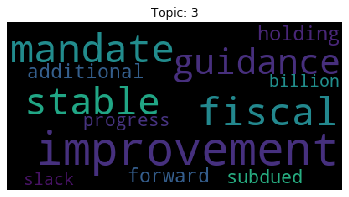

Model PLSI, Topic (0) top unique features:
[('participant', 20.00145639755817),
 ('real', 8.464097042671915),
 ('survey', 4.601541273634284),
 ('target', 4.558029552478413),
 ('yield', 4.135725250920945),
 ('net', 3.733851615896036),
 ('gdp', 3.6114797062843897),
 ('including', 3.4804173127377824),
 ('fomc', 3.4518760698083333),
 ('based', 2.882305947525664),
 ('solid', 2.795227530889509),
 ('core', 2.7013179659338142),
 ('moved', 2.4460960128815668),
 ('downside', 2.4251135611522616)]
Model PLSI, Topic (1) top unique features:
[('inventory', 5.876327408225191),
 ('aggregate', 3.2020756774859556),
 ('service', 2.6829707729133228),
 ('stock', 2.6662359276276946),
 ('sustainable', 2.5831911255231614),
 ('major', 2.4580656869557416),
 ('country', 2.427548234371071),
 ('ahead', 2.2816125985795392),
 ('retail', 2.1618265944783506),
 ('favorable', 2.1198226570743484),
 ('rising', 2.1188073002493337),
 ('productivity', 2.0631257014844024),
 ('industry', 2.057728586098315),
 ('strength', 2.012

In [11]:
    for name, model in models.items():
        print('Model', name)
        topics = wordcloud_features(model.components_, 20, feature_names, unique=True, plot=True)
        plt.show()
        for topic, features in topics.items():
            print('Model {}, Topic ({}) top unique features:'.format(name, topic))
            pprint(features)


### comment